In [1]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
from datetime import timedelta as td
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = None 

In [3]:
jobs = pd.read_csv("../data/jobs_data.csv")

In [4]:
logs_sbatch = pd.read_csv("../data/slurm_sbatch.csv")

In [5]:
logs_sbatch['RETURNCODE'].unique()

array([0, 1], dtype=int64)

In [6]:
logs_sbatch['DATE'] = pd.to_datetime(logs_sbatch['DATE'])
logs_sbatch = logs_sbatch.sort_values('DATE')

In [7]:
logs_sbatch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61247 entries, 30840 to 30839
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    61247 non-null  int64         
 1   DATE          61247 non-null  datetime64[ns]
 2   USER          61247 non-null  int64         
 3   RETRY         61247 non-null  int64         
 4   TIME          61247 non-null  float64       
 5   RETURNCODE    61247 non-null  int64         
 6   COMMAND       61247 non-null  object        
 7   SERVER        61247 non-null  object        
 8   TESTING       61247 non-null  bool          
 9   UNRESPONSIVE  61247 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 4.3+ MB


In [8]:
logs_timeout = logs_sbatch[(logs_sbatch['RETURNCODE'] == 1) & (logs_sbatch['TIME'] > 15)]
logs_complete = logs_sbatch[(logs_sbatch['RETURNCODE'] == 0) & (logs_sbatch['TIME'] <= 15)]

In [9]:
logs_timeout['ROLL1HOUR'] = (logs_timeout.rolling('1h', on='DATE')['UNRESPONSIVE'].count())
logs_complete['ROLL1HOUR'] = (logs_complete.rolling('1h', on='DATE')['TESTING'].count())
logs_timeout['ROLL24HOUR'] = (logs_timeout.rolling('24h', on='DATE')['UNRESPONSIVE'].count())
logs_complete['ROLL24HOUR'] = (logs_complete.rolling('24h', on='DATE')['TESTING'].count())

In [10]:
logs_timeout

,Unnamed: 0,DATE,USER,RETRY,TIME,RETURNCODE,COMMAND,SERVER,TESTING,UNRESPONSIVE,ROLL1HOUR,ROLL24HOUR
230,1102,2020-10-18 06:16:25.392946,9204,0,20.037672,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5572a7c77310.3390891/bl_23341e2dd5ae']",ce6,False,True,1.0,1.0
233,1110,2020-10-18 06:38:44.172473,9204,0,20.038736,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5572a841eb00.3390891/bl_9f06196a57ac']",ce6,False,True,2.0,2.0
31060,156148,2020-10-18 06:53:44.272915,9204,0,20.038464,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']",ce5,False,True,3.0,3.0
31061,156149,2020-10-18 06:54:04.322412,9204,1,20.048906,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']",ce5,False,True,4.0,4.0
31064,156162,2020-10-18 07:47:25.825172,9204,0,20.082628,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1d9e86b90.1559883/bl_fa5Tsv']",ce5,False,True,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
60005,307135,2021-09-24 18:14:35.862916,9204,0,20.041436,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55df4d8ba260.776217/bl_Fv00Ue']",ce5,False,True,1.0,38.0
60008,307146,2021-09-24 19:13:14.894282,9204,0,20.051321,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55df49c18a10.776217/bl_qE6GEZ']",ce5,False,True,2.0,39.0
60722,311411,2021-10-02 08:14:16.557499,9204,0,19.083227,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x555672903f40.1189023/bl_nC0gWA']",ce5,False,True,1.0,1.0
60762,311644,2021-10-02 18:29:08.267199,9204,0,20.043146,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5556727577c0.1189023/bl_g77bis']",ce5,False,True,1.0,2.0


<AxesSubplot:xlabel='DATE'>

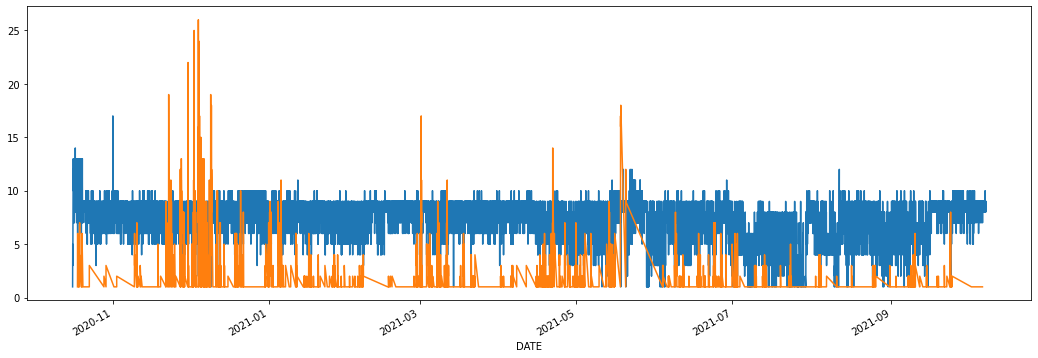

In [11]:
plt.figure(figsize=(18,6))
logs_complete.set_index('DATE')['ROLL1HOUR'].plot()
logs_timeout.set_index('DATE')['ROLL1HOUR'].plot()

<AxesSubplot:xlabel='DATE'>

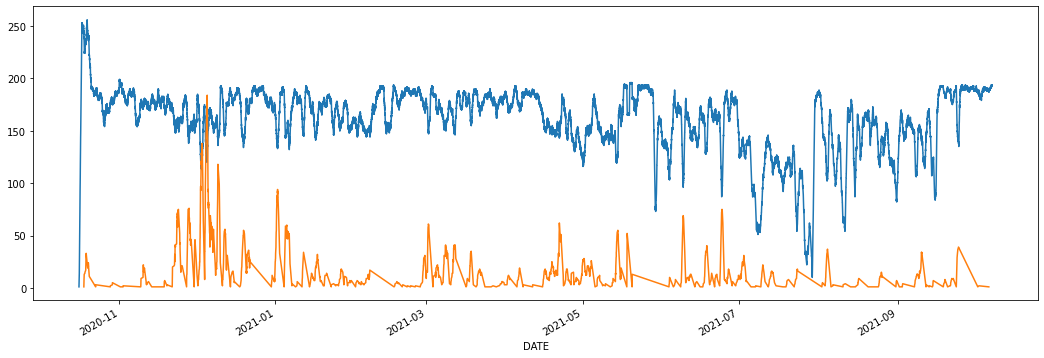

In [12]:
plt.figure(figsize=(18,6))
logs_complete.set_index('DATE')['ROLL24HOUR'].plot()
logs_timeout.set_index('DATE')['ROLL24HOUR'].plot()

In [13]:
jobs['END'] = pd.to_datetime(jobs['END'])

In [16]:
jobs_by_week = jobs.groupby(pd.Grouper(key='END', freq='W'))['JOBID'].count()/168
jobs_by_week = jobs_by_week.reset_index()

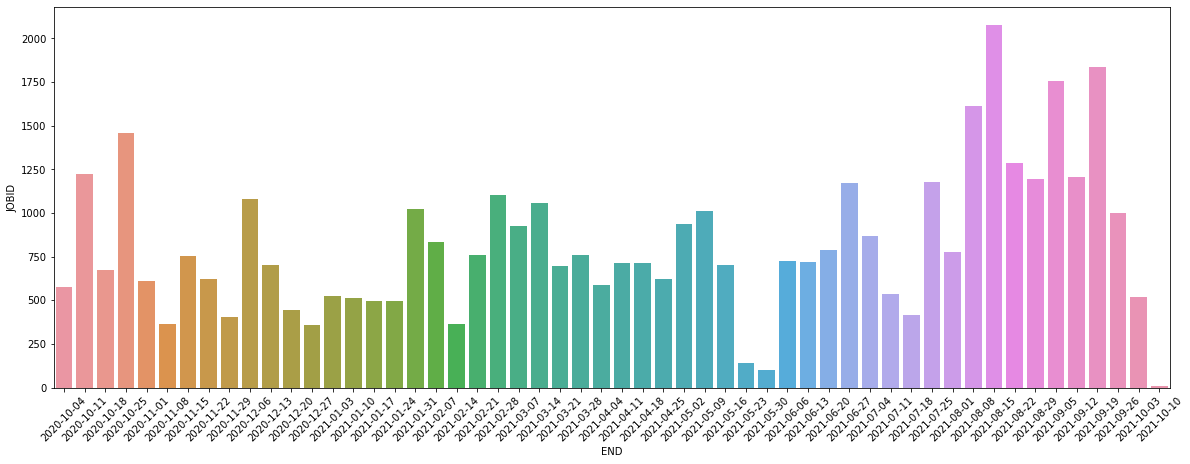

In [17]:
fig, ax = plt.subplots(figsize=(20, 7))

x_dates = jobs_by_week['END'].dt.strftime('%Y-%m-%d')

sns.barplot(x='END', y='JOBID', data=jobs_by_week, ax=ax, hue=x_dates, dodge=False)

ax.set_xticklabels(labels=x_dates, rotation=45)
ax.get_legend().remove()

In [18]:
logs_timeouts_by_week_nomay = logs_timeouts_by_week[(logs_timeouts_by_week['DATE'] < '2021-05-16') | (logs_timeouts_by_week['DATE'] > '2021-05-29')]
logs_timeouts_by_week_nomay

NameError: name 'logs_timeouts_by_week' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))

x_dates = logs_timeouts_by_week_nomay['DATE'].dt.strftime('%Y-%m-%d')

sns.barplot(x='DATE', y='UNRESPONSIVE', data=logs_timeouts_by_week_nomay, hue=x_dates, dodge=False)

ax.set_xticklabels(labels=x_dates, rotation=45)
ax.get_legend().remove()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))

x_dates = logs_timeouts_by_week['DATE'].dt.strftime('%Y-%m-%d')

sns.barplot(x='DATE', y='UNRESPONSIVE', data=logs_timeouts_by_week, hue=x_dates, dodge=False)

ax.set_xticklabels(labels=x_dates, rotation=45)
ax.get_legend().remove()

In [ ]:
logs_t_o_dayofweek = logs_timeout.groupby(logs_timeout['DATE'].dt.weekday).count()

logs_complete_dayofweek = logs_complete.groupby(logs_complete['DATE'].dt.weekday).count()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.barplot(x='DATE', y='UNRESPONSIVE', data=logs_t_o_dayofweek)

fig, ax = plt.subplots(figsize=(20, 7))

sns.barplot(x='DATE', y='TESTING', data=logs_complete_dayofweek)

In [ ]:
logs_timeouts_hour = logs_timeout.groupby(pd.Grouper(key='DATE', freq='H'))['UNRESPONSIVE'].count()
logs_timeouts_hour = logs_timeouts_hour.reset_index()
logs_timeouts_hour

jobs